# AutoGluon (AG)
- A very particular Approach to AutoML
- Automates Preprocessing by applying COMMON preprocessing approaches to each feature
- It tests out several COMMON Forecasting approaches in a given time
- Combines the best into a weighted Ensemble 

In [ ]:
!pip install -q pandas
!pip install -q autogluon
!pip install -q numpy==1.26.4
!pip install -q scipy==1.14.1

In [ ]:
# Download the Dataset, it only works on Linux Systems like Colab 
# TODO: For BTW25 your own Dataset will be required
!wget https://ember-climate.org/app/uploads/2023/12/european_wholesale_electricity_price_data_hourly.zip  # For Win: Download dataset with link, unzip, and put into flderdefined below
import zipfile
with zipfile.ZipFile("european_wholesale_electricity_price_data_hourly.zip", 'r') as zip_ref:
    zip_ref.extractall("../data")

In [1]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
# Define Hyperparameter & common CLI Arguments
time_column = "Datetime (UTC)"
prediction_length = 24
target_column = "Price (EUR/MWhe)"
# AG takes as much time as it gets to find the optimal solution (sometimes less but never more) usually the more time the better solutions it finds 
time_limit = 10*60 # in seconds --> 10min

In [3]:
# Read Data in and make a very bad Train Test Split
# TODO: Better Train-Test Split
df = pd.read_csv("../data/european_wholesale_electricity_price_data_hourly/Germany.csv")
# TS Data is usually sorted already but just to make sure...
df[time_column] = pd.to_datetime(df[time_column])
df = df.sort_values(by=time_column) 

# The last day is test data (for VISUALIZATION ONLY real test set should be much larger)
test = df[-prediction_length:] 
train = df[:-prediction_length]

train.head(5)

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Germany,DEU,2015-01-01 00:00:00,2015-01-01 01:00:00,17.93
1,Germany,DEU,2015-01-01 01:00:00,2015-01-01 02:00:00,15.17
2,Germany,DEU,2015-01-01 02:00:00,2015-01-01 03:00:00,16.38
3,Germany,DEU,2015-01-01 03:00:00,2015-01-01 04:00:00,17.38
4,Germany,DEU,2015-01-01 04:00:00,2015-01-01 05:00:00,16.38


In [4]:
# Convert Data Into The Format requested by AG
train_data = TimeSeriesDataFrame.from_data_frame(
    train,
    id_column="Country",
    timestamp_column=time_column,
)
test_data = TimeSeriesDataFrame.from_data_frame(
    test,
    id_column="Country",
    timestamp_column=time_column,
)
train_data.head()

ISO3 Code     Datetime (Local)  Price (EUR/MWhe)
item_id timestamp                                                           
Germany 2015-01-01 00:00:00       DEU  2015-01-01 01:00:00             17.93
        2015-01-01 01:00:00       DEU  2015-01-01 02:00:00             15.17
        2015-01-01 02:00:00       DEU  2015-01-01 03:00:00             16.38
        2015-01-01 03:00:00       DEU  2015-01-01 04:00:00             17.38
        2015-01-01 04:00:00       DEU  2015-01-01 05:00:00             16.38

In [5]:
# Setup Model
predictor = TimeSeriesPredictor(
    target=target_column,  # Which Column shall be Forecasted
    prediction_length=prediction_length,  # 24h forecast
    freq="h",  # one Value/forecast per hour
)

# Train Model
predictor = predictor.fit(
    train_data=train_data,
    time_limit=time_limit,  # 10 min (in seconds) - time for training (more time sometimes leads to better results)
    presets="medium_quality",  # Sets the remaining Hyperparameters to good defaults during development (for deployment use "best_quality" it takes longer but it is usually better)
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'AutogluonModels\ag-20241013_152225'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          20
GPU Count:          1
Memory Avail:       6.16 GB / 31.73 GB (19.4%)
Disk Space Avail:   497.83 GB / 951.65 GB (52.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'Price (EUR/MWhe)',
 'time_limit': 600,
 'verbosity': 2}

Provided train_data has 81048 rows, 1 time series. Median time series length is 

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


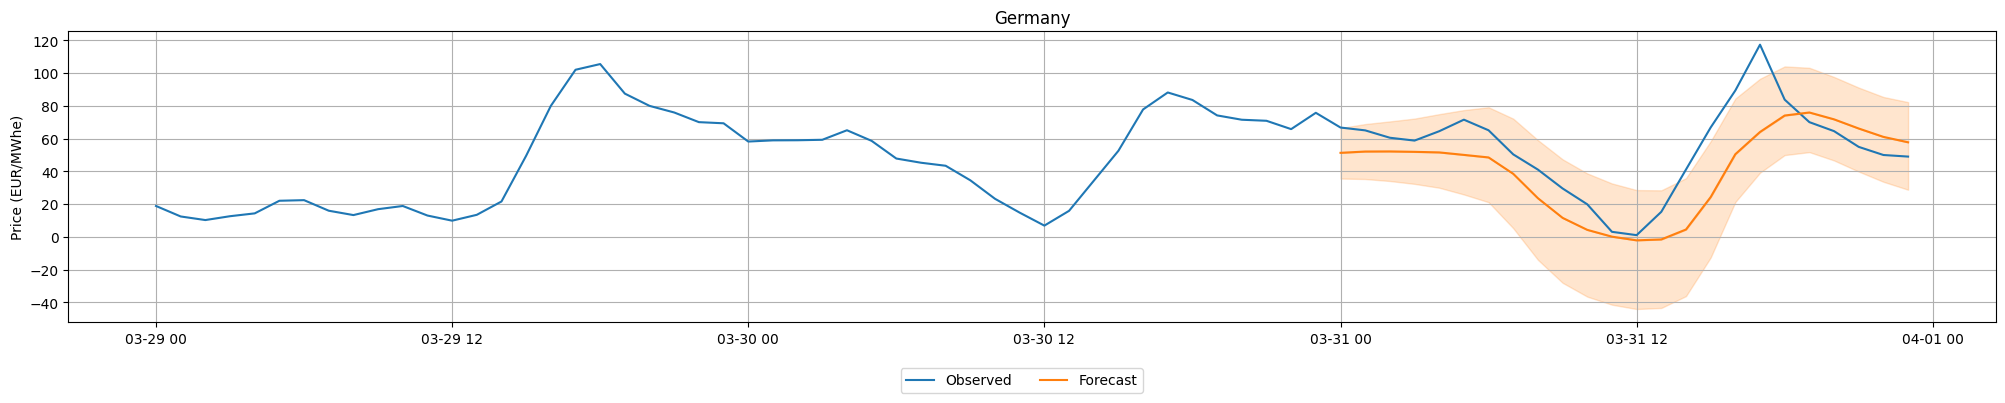

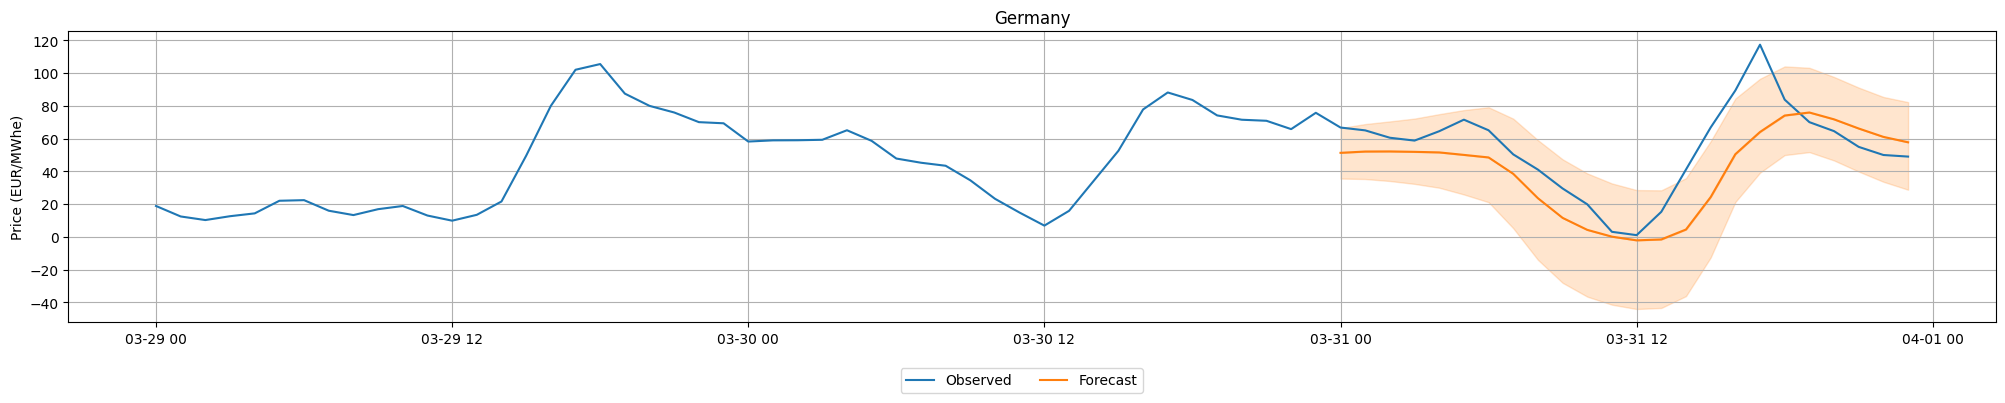

In [6]:
# Make Predictions
predictions = predictor.predict(data=train_data) # Task: CONTINUE the Train set for prediction_length hours
target = pd.concat([train_data[-48:], test_data]) # Concat Train and Test for beautiful plot
# Plot Predictions
predictor.plot(target, predictions=predictions, max_num_item_ids=1)

# Further Work Ideas
## Optimizing & Tuning 
- AG supports several approaches to tuning 
- Goal: Squeeze the last bit of performance out of it
- First, you might want to increase the time_limit and set the used preset to best_quality --> this is as good as default AG gets. Note: Don't forget to reverse those changes afterward
#### Hyperparameter Tuning
- AG supports [Hyperparameter-tuning](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html#hyperparameter-tuning) 
- Will likely take much longer to find a solution, but it might be much better
#### Include More Data
- AG Supports Known and Unknown Covariates, so adding more Features to the data might be very helpful
    - Covariates ~ Time-Series that correlate to the Time-Series that shall be predicted and provide information to support predicting our target, e.g. Weather for Solar Energy Production (On sunny days, more is produced than on Cloudy Days).
    - Known-Covariates ~ Covariates that are known for the future e.g. It is known which week-day is tomorrow, or when the next public Holiday will be
    - Unknown-Covariates ~ Covariates we only know in hindsight, e.g. The Weather we know how it was yesterday and today, but we don't know how it will be tomorrow (Though we could make predictions)
- AG also supports Static Features, the Intuition is:
    - Those Features make it easier to find Patterns across different Time-Series, by helping the model to cluster or, rather, compare the Time-Series via those features
    - E.g. Time-Series 1 & 2 Belong to Germany and Time-Series 3 to France --> Shall the model now Forecast a 4th Time-Series which belongs to Germany then it "knows" that patterns found on 1 & 2 are likely more relevant than those specific to 3  
- [Finetune Large Chronos](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html) (requires GPU) 
    - Chronos is a powerful Transformer-based approach that can easily be trained (fine-tuned) via AG (but not as easily customized)
- AG promises that it can generalize across several similar Time-Series, so including more Data, e.g. from different Nations, might help too
#### Better Metrics
- AutoGluon chooses the best model and hyperparameters based on a given metric 
- By default, it uses WQL, which is a good default, if we don't know much about the given task 
- However, you might care more about predicting peak Values correctly than the common scenario or have other Considerations you would like AG to take into account
- Then custom Metrics are a good starting point
#### Further Resources:
- https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-indepth.html 
## Hacking AG
- For the more Adventurous Souls that want to dig deep
- Fork [AutoGluon](https://github.com/autogluon/autogluon)
- Make Adjustments to it, e.g.:
    - Develop new Ensemble Strategies
    - Include your own models like LSTM, xLSTM, ...
    - Add better Hyperparameter-Optimization Strategies (Currently (Mostly) Random Search Only which is slow i.e. finds usually worse solutions in the same amount of time than other strategies)